# Example using California Housing Dataset

## Training

In [1]:
import torch
import numpy as np
from sklearn.datasets import fetch_california_housing
from stellarperceptron.model import StellarPerceptron

device = "cuda"

housing = fetch_california_housing()
training_labels = np.column_stack([housing.data, housing.target])
obs_names = housing.feature_names + ["HouseValue"]


nn_model = StellarPerceptron(
    vocabs=obs_names,
    embedding_dim=32,
    embedding_activation="gelu",
    encoder_head_num=4,
    encoder_dense_num=128,
    encoder_dropout_rate=0.1,
    encoder_activation="gelu",
    encoder_n_layers=2,
    diffusion_dense_num=64,
    diffusion_n_layers=2,
    diffusion_num_steps=100,
    device=device,
    mixed_precision=False,
    compile_model=False,
    folder="trained_california_model",
)

nn_model.optimizer = torch.optim.AdamW(nn_model.torch_model.parameters(), lr=5.0e-3)

# There is no output labels, this model only has one output node depending what information you request
# Here we choose a set of labels from inputs as possible information request to quickly train this model
# In principle, any labels in inputs can be requested in output
nn_model.fit(
    # give all because some of them will be randomly chosen shuffled in random order for each stars in each epoch
    inputs=training_labels,
    inputs_name=obs_names,
    # during training, one of these will be randomly chosen for each stars in each epoch
    outputs_name=obs_names,
    batch_size=128,
    val_batchsize_factor=10,
    epochs=512,
    lr_scheduler=lambda optimizer: torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=64,
        T_mult=1,
        eta_min=1.0e-5,
        last_epoch=-1,  # means really the last epoch ever
    ),
    length_range=(0, 10),
    terminate_on_nan=True,
    checkpoint_every_n_epochs=0,
)

c:\Users\Henry\Documents\Github\stars_foundation_diffusion\stellarperceptron\ddpm.py:44: UserWarning: In ideal case, cond_dim equals to dim_out. Now cond_dim (32) is linearly mapped to dim_out (64) so you have additional trainable parameters.
  warnings.warn(
  0%|          | 0/512 [00:00<?, ?epoch/s]c:\Users\Henry\miniconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 512/512 [07:57<00:00,  1.07epoch/s]


## Inference

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stellarperceptron.model import StellarPerceptron
from sklearn.datasets import fetch_california_housing
from astroNN.shared.matplotlib import pylab_style

pylab_style(paper=True)

housing = fetch_california_housing()
val_labels = np.column_stack([housing.data, housing.target])
obs_names = housing.feature_names + ["HouseValue"]
print(obs_names)
val_labels_df = pd.DataFrame(val_labels, columns=obs_names)


nn_model = StellarPerceptron.load(
    "./trained_california_model/",
    device="cuda:1",
    mixed_precision=True,
    compile_model=False,
)
print(
    f"Total number of parameters: {nn_model.get_parameters_sum()}, of which {nn_model.torch_model.diffusion_head.get_parameters_sum()} from the DDPM head"
)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'HouseValue']


c:\Users\Henry\Documents\Github\stars_foundation_diffusion\stellarperceptron\ddpm.py:44: UserWarning: In ideal case, cond_dim equals to dim_out. Now cond_dim (32) is linearly mapped to dim_out (64) so you have additional trainable parameters.
  warnings.warn(


Total number of parameters: 47425, of which 21377 from the DDPM head


c:\Users\Henry\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(


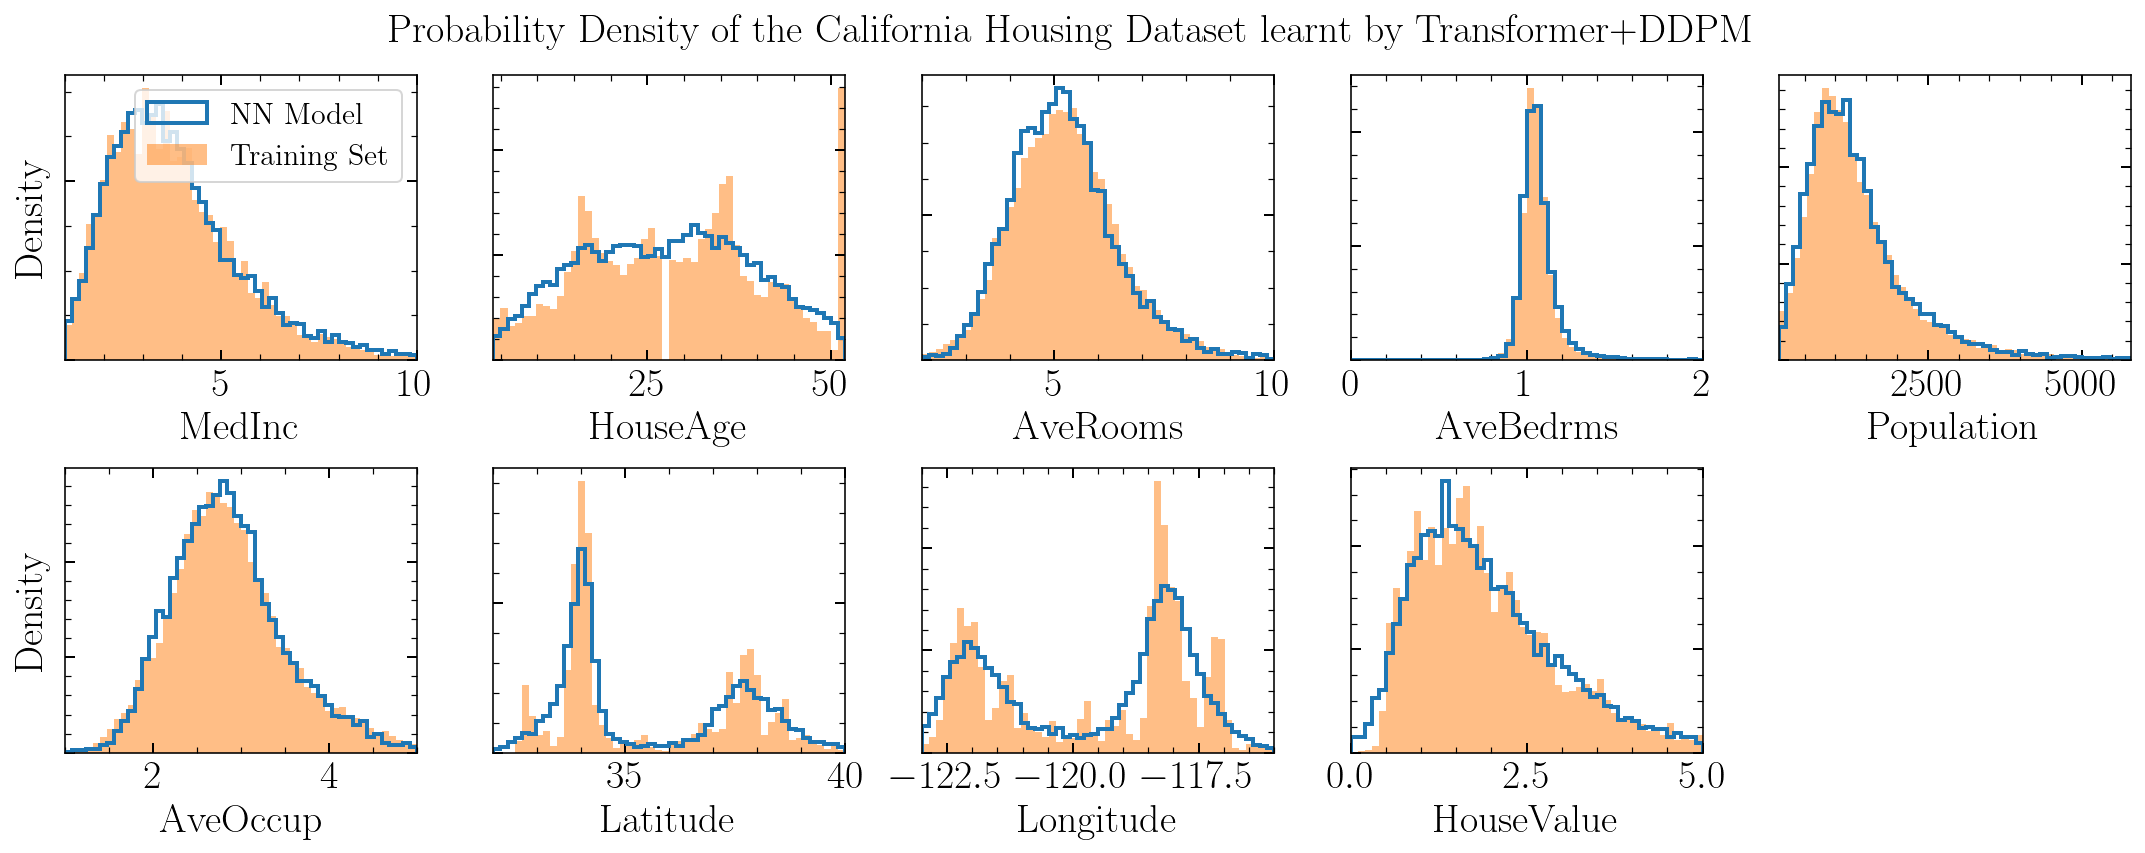

In [2]:
fig, (ax_top, ax_bottom) = plt.subplots(2, 5, figsize=(15, 6))

for i, obs_name in enumerate(obs_names[:5]):
    nn_pred = nn_model.predict_samples(request_tokens=obs_name, size=10000)
    low = int(np.percentile(val_labels_df[obs_name], 1))
    high = int(np.percentile(val_labels_df[obs_name], 99))
    ax_top[i].hist(
        nn_pred,
        bins=50,
        histtype="step",
        lw=2.0,
        range=(low, high),
        density=True,
        label="NN Model",
        rasterized=True,
    )
    ax_top[i].hist(
        val_labels_df[obs_name],
        bins=50,
        density=True,
        range=(low, high),
        alpha=0.5,
        label="Training Set",
        rasterized=True,
    )
    ax_top[i].set_xlim(low, high)
    ax_top[i].set_xlabel(obs_name)
    ax_top[i].set_yticklabels([])
ax_top[0].legend()
ax_top[0].set_ylabel("Density")

for i, obs_name in enumerate(obs_names[5:]):
    nn_pred = nn_model.predict_samples(request_tokens=obs_name, size=10000)
    low = int(np.percentile(val_labels_df[obs_name], 1))
    high = int(np.percentile(val_labels_df[obs_name], 99))
    ax_bottom[i].hist(
        nn_pred,
        bins=50,
        histtype="step",
        lw=2.0,
        range=(low, high),
        density=True,
        label="NN Model",
        rasterized=True,
    )
    ax_bottom[i].hist(
        val_labels_df[obs_name],
        bins=50,
        density=True,
        range=(low, high),
        alpha=0.5,
        label="Training Set",
        rasterized=True,
    )
    ax_bottom[i].set_xlim(low, high)
    ax_bottom[i].set_xlabel(obs_name)
    ax_bottom[i].set_yticklabels([])
ax_bottom[0].set_ylabel("Density")
fig.suptitle(
    "Probability Density of the California Housing Dataset learnt by Transformer+DDPM"
)
fig.delaxes(ax_bottom[-1])

fig.tight_layout()
fig.savefig("figs/california_housing_density.pdf")

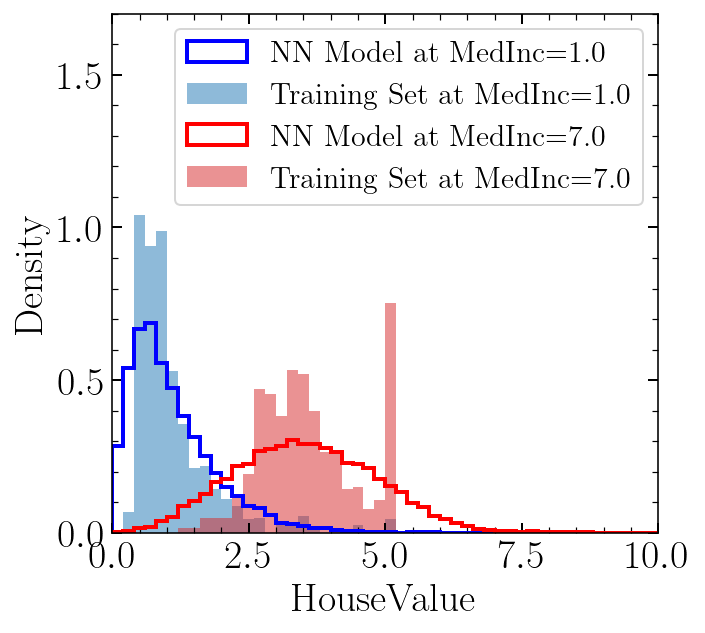

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4.5))

nn_HouseValue_pred = nn_model.predict_samples(
    inputs=[1.0], input_tokens=["MedInc"], request_tokens="HouseValue", size=10000
)
ax1.hist(
    nn_HouseValue_pred,
    bins=50,
    range=(0, 10),
    density=True,
    histtype="step",
    color="b",
    lw=2.0,
    label="NN Model at MedInc=1.0",
    rasterized=True,
)
ax1.hist(
    val_labels_df[
        (val_labels_df["MedInc"] > 1.0 - 0.5) & (val_labels_df["MedInc"] < 1.0 + 0.5)
    ]["HouseValue"].to_numpy(),
    color="C0",
    bins=50,
    range=(0, 10),
    alpha=0.5,
    density=True,
    label="Training Set at MedInc=1.0",
    rasterized=True,
)

nn_HouseValue_pred = nn_model.predict_samples(
    inputs=[7.0], input_tokens=["MedInc"], request_tokens="HouseValue", size=10000
)
ax1.hist(
    nn_HouseValue_pred,
    bins=50,
    range=(0, 10),
    density=True,
    histtype="step",
    color="r",
    lw=2.0,
    label="NN Model at MedInc=7.0",
    rasterized=True,
)
ax1.hist(
    val_labels_df[
        (val_labels_df["MedInc"] > 7.0 - 0.5) & (val_labels_df["MedInc"] < 7.0 + 0.5)
    ]["HouseValue"].to_numpy(),
    color="C3",
    bins=50,
    range=(0, 10),
    alpha=0.5,
    density=True,
    label="Training Set at MedInc=7.0",
    rasterized=True,
)

ax1.set_xlim(0, 10.0)
ax1.set_ylim(0, 1.7)
ax1.set_xlabel("HouseValue")
ax1.set_ylabel("Density")
ax1.legend(loc="best")
fig.tight_layout()
fig.savefig("figs/california_housing_conditional_density.pdf")